In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["AUTO_UNWRAP_TRANSFORMED_ENV"] = "0"
os.environ["CAPTURE_NONTENSOR_STACK"] = "0"
# Set the desired root path
desired_root_path = '/home/vmoens/mlgym'
# Change the current working directory
os.chdir(desired_root_path)


In [2]:
import tensordict
tensordict.set_list_to_stack(True).set()

import argparse
import ast
import gymnasium as gym
import json
import re
import sys
import torch
import yaml
from simple_parsing import parse
from simple_parsing.helpers.fields import field
from simple_parsing.helpers.flatten import FlattenedAccess
from simple_parsing.helpers.serialization.serializable import FrozenSerializable

from mlgym import CONFIG_DIR
from pprint import pprint
from functools import partial
from torchrl.envs import GymWrapper, TransformedEnv, StepCounter
from transformers import GenerationConfig
from mlgym.backend.base import APIStats, ModelArguments
from mlgym.agent.base import (
    AgentArguments,
)
from mlgym.utils.extras import get_devices, multiline_representer
from mlgym.environment.env import EnvironmentArguments
# from mlgym.torchrl.models import MetagenModel
from mlgym.torchrl.transforms import make_env
from torchrl.envs import ConditionalSkip


try:
    from rich_argparse import RichHelpFormatter
except ImportError:
    msg = "Please install the rich_argparse package with `pip install rich_argparse`."
    raise ImportError(msg)


/home/vmoens/.conda/envs/mlgym/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-08 03:17:47,455	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Setting up logger for name='MLGym'
Setting up logger for name='env_utils'
Setting up logger for name='config'


# Building your model

TorchRL relies on the tensordict.nn API.
The main components are:

- [TensorDictModule](https://pytorch.org/tensordict/main/reference/generated/tensordict.nn.TensorDictModule.html): Runs a module (forward or any other method) or a function given a leaf or one or more node of the tensordict. THe nodes are indicated by the `in_keys` arg, the output entries by the `out_keys`. 
- [TensorDictSequential](https://pytorch.org/tensordict/main/reference/generated/tensordict.nn.TensorDictSequential.html): Runs a sequence of modules that take a tensordict as input and output a tensordict. Any function is accepted.

Both classes are `nn.Module` subclasses: they will expose the parameters and buffers as well as submodules.

We use unsloth because it's easy to pull any model out of it.

TypeError: EngineArgs.__init__() got an unexpected keyword argument 'device_config'

In [ ]:
llm = vllm.LLM("Qwen/Qwen2.5-3B", device_config="cpu")
from torchrl.modules import vLLMWrapper
model = vLLMWrapper(llm)
tokenizer = llm.get_tokenizer()

This code block is a simplified version of the get_args from the Agent's main code.
We keep the agent config, even though we're not really using it.

In [ ]:
def get_args(args=None) -> "ScriptArguments":
    """Parse command line arguments and return a ScriptArguments object.

    Args:
        args: Optional list of arguments to parse. If not provided, uses sys.argv.
    """
    from run import ScriptArguments
    defaults = ScriptArguments(
        environment=EnvironmentArguments(
            task_config_path="tasks/prisonersDilemma.yaml",
            max_steps=10,
            seed=42,
            container_type="podman",
            verbose=False, 
            aliases_file="../docker/aliases.sh",
        ), 
        agent=AgentArguments(
            model=ModelArguments(
                model_name="metagen:gpt-4-turbo",
                total_cost_limit=0.0,
                per_instance_cost_limit=3.0,
                temperature=0.0,
                top_p=0.95, ), 
            agent_config_path=CONFIG_DIR / "agents" / "default.yaml", ), 
    )
    yaml.add_representer(str, multiline_representer)

    args = parse(
        ScriptArguments,
        default=defaults,
        add_config_path_arg=False,
        args=args,
        formatter_class=RichHelpFormatter,
        description="Run inference.", )

    return args


In [ ]:
torch.manual_seed(0)
args = get_args(["--container_type", "podman", "--aliases_file", "./docker/aliases.sh", "--max_steps", "1000"])

We build the base env with `gym.make`

In [ ]:
# base_env = gym.make(f"mlgym/{args.environment.task.id}", devices=["cpu_0"], args=args.agent).unwrapped
base_env = gym.make(f"mlgym/{args.environment.task.id}", devices=["cpu_0"]).unwrapped

The `wrap_env` creates a TransformedEnv with all the required transforms

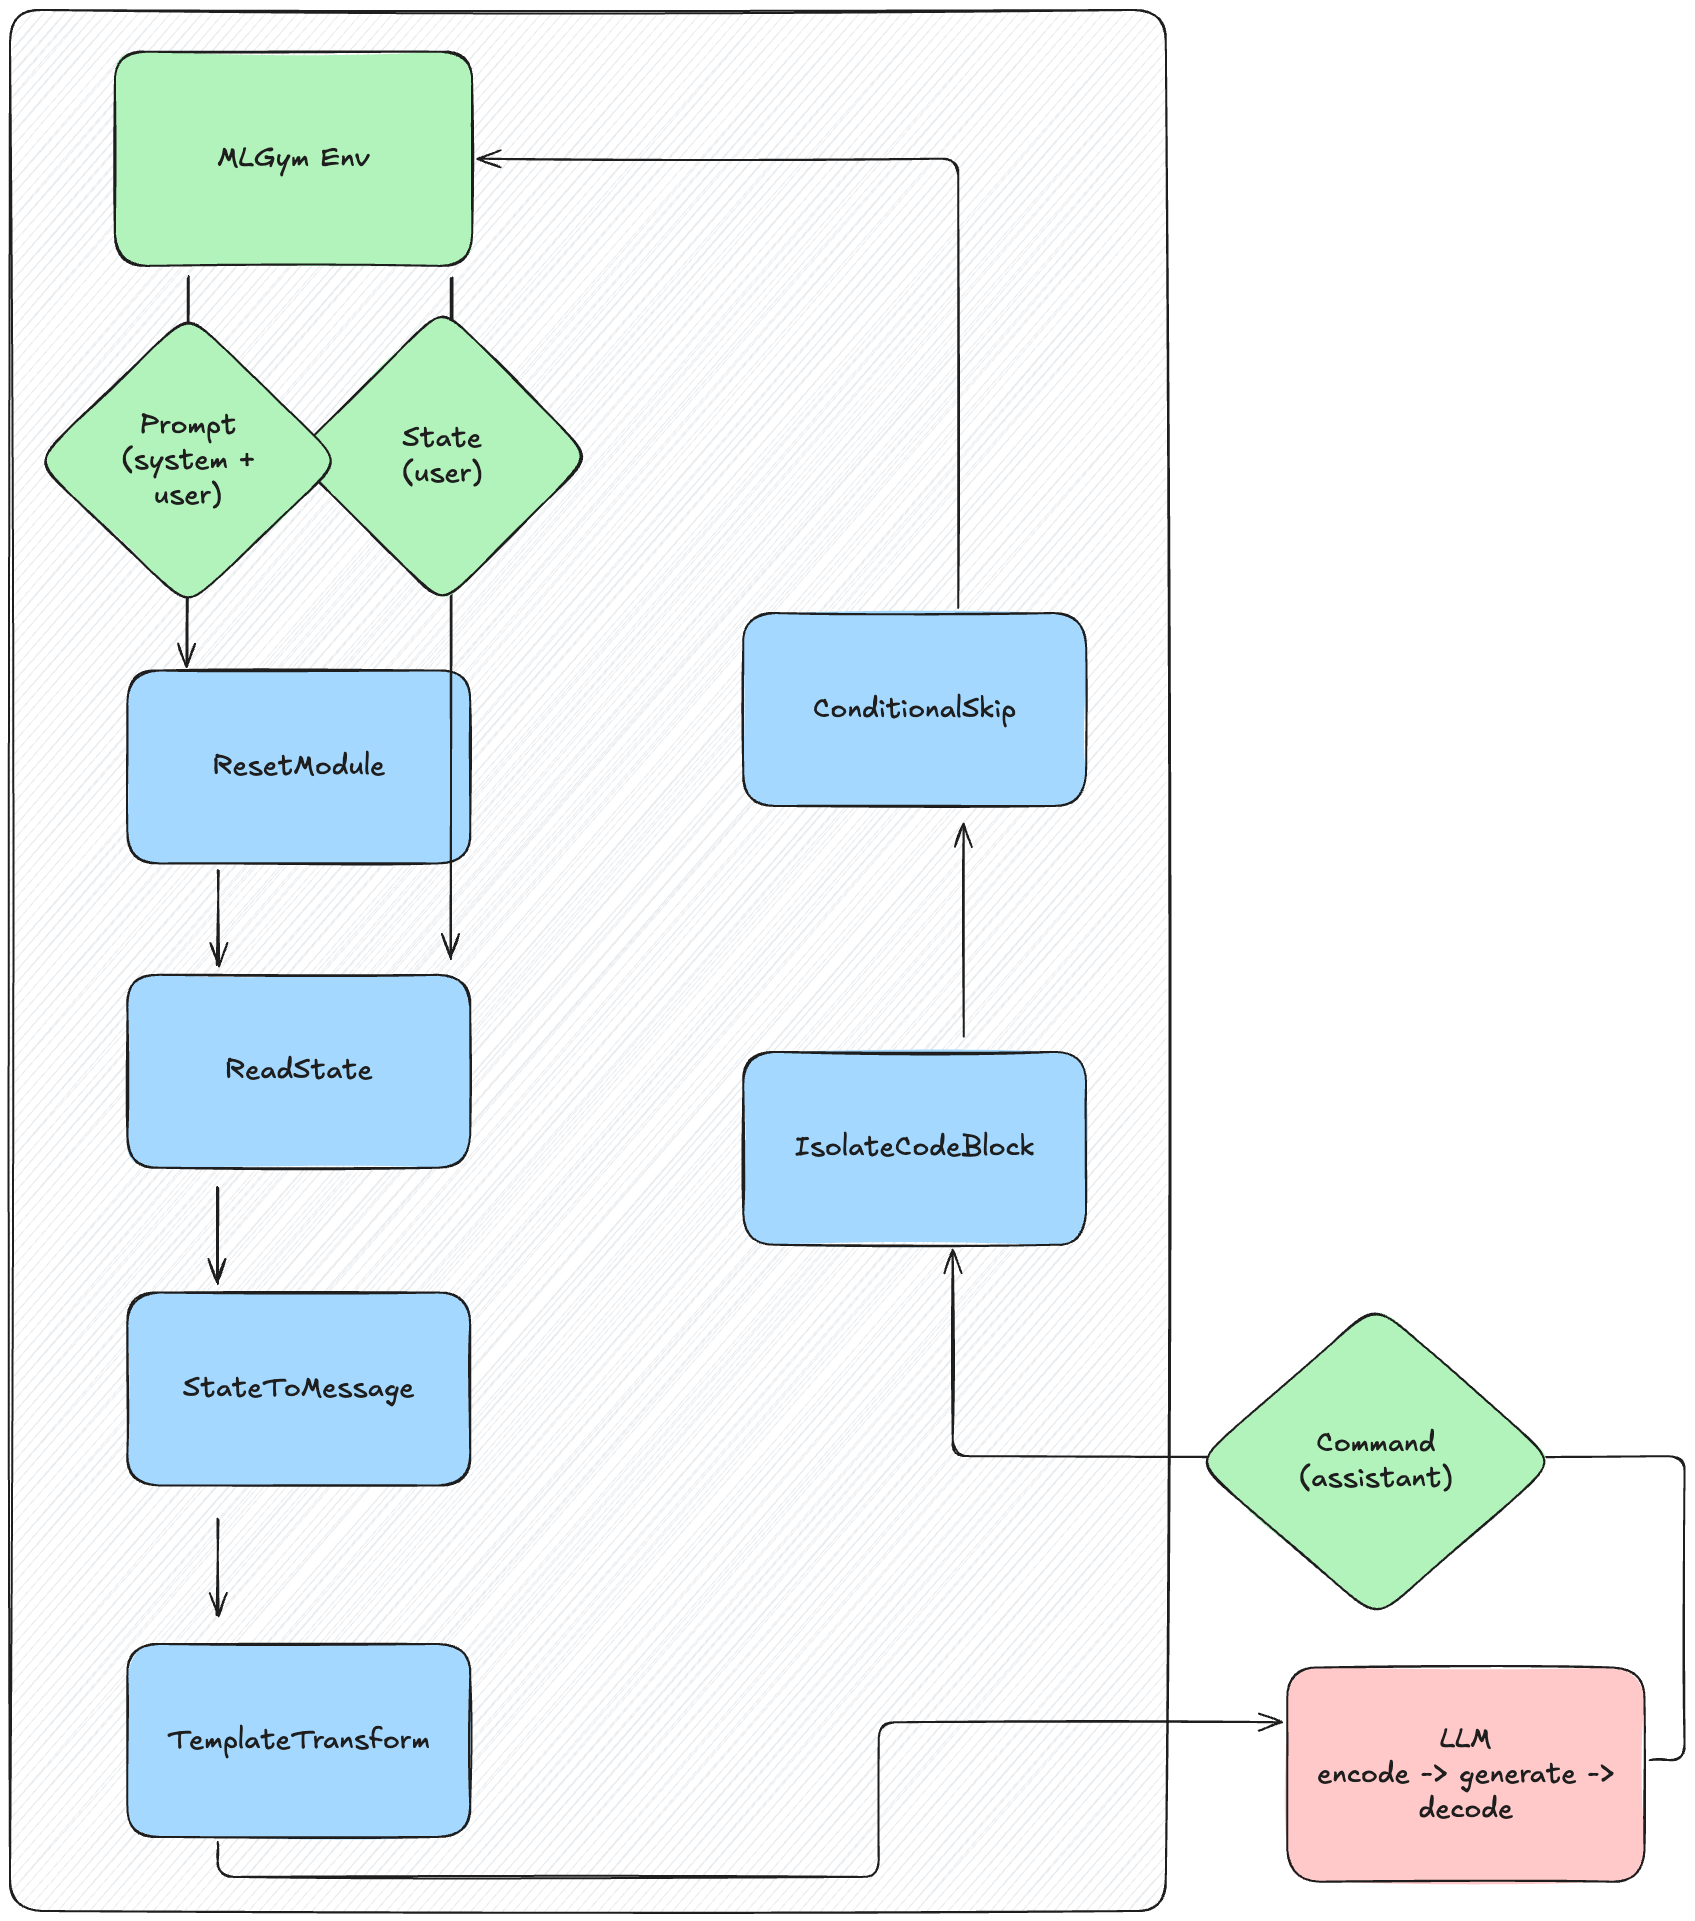


In [ ]:
env = make_env(args, tokenizer)
env

In [ ]:
# Let's add a StepCounter from torchrl
env.append_transform(StepCounter())

In [ ]:
env.config.tools_handler.command_docs

In [ ]:
r = env.reset()

We can look at our data structure. 

In [ ]:
r

The interesting part is the history: it's a stack of agent/content info. Each history in the rollout stack will contain all history nodes up to that point (see below).

In [ ]:
r["history"]

Let's see what our model does. After executing it, our tensordict should have a bunch of new entries. The most important thing we want to look at is the action (we just represent these)

In [ ]:
r_inp = lazy_stack([r])
r_inp["text"]

In [ ]:
from tensordict import lazy_stack
print("Executing model", end="\n\n")
r = model(r_inp)
print(r.select(*model.out_keys))

In [ ]:
r["text_response"]

And now our environment step: `env.step` takes the action, isolates the command, and passes that to MLGym. 

Then MLGym gives an output (observation) as well as a state and the env transforms make the job of formattting all of that for our env.

The new data is written in the `"next"` field of the tensordict. 

In [ ]:
print("Executing step", end="\n\n")
r = env.step(r)
r

The `step_mdp` method will bring that to the root (and do some filtering, like removing the reward etc).

In [ ]:
print("Step in the mdp (t' -> t)", end="\n\n")
r = env.step_mdp(r)
r

We can have a look at the history so far. It contains 4 elements, the first two from the `env.reset` ("system" and "user"), the first call to the model ("assistant") then the result from the call to env.step ("user"):

In [ ]:
pprint(list(zip(r["history"].role, r["history"].content)))

To recap: a simple rollout can be executed as follows:

In [ ]:
r = env.reset()
for _ in range(5):
    print("Executing model", end="\n\n")
    r = model(r)
    print("Executing step", end="\n\n")
    r = env.step(r)
    r = env.step_mdp(r)
pprint(list(zip(r["history"].role, r["history"].content)))

That's a bit tedious, and we can anticipate that all envs / model combinations will work that way so we can use `env.rollout` instead.

In [ ]:
r = env.rollout(20, policy=model, callback=lambda self, td: print(td["step_count"]))
r

Importantly, `rollout` returns a stack of all steps undertaken in the env.
We can index it to get the step we want

In [ ]:
# last step
r[-1]

In [ ]:
# Quick check: the last chat_str must match the chat_str produced during the step before
r[-2]["next", "chat_str"] == r[-1]["chat_str"]

Let's see what our model has produced as output.
First, take the last step:

In [ ]:
last_step = r[-1]

Then, take the history and isolate all nodes where the role is "assistant"

In [ ]:
from pprint import pprint
role_is_assistant = torch.tensor([i for i, item in enumerate(last_step["history"].role) if item == "assistant"])
# we can directly index the history
pprint(last_step["history"][role_is_assistant].content)